In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv("dataset.csv")

In [74]:
data.columns

Index(['Cost', 'Weight', 'Weight1', 'Length', 'Height', 'Width'], dtype='object')

There are 5 features namely 'Weight', 'Weight1', 'Length', 'Height', 'Width' and "Cost" is the target variable.

In [75]:
# Know the shape of data
data.shape

(159, 6)

There are 160 rows and 6 columns available in the dataset.

In [76]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159 entries, 0 to 158
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Cost     159 non-null    float64
 1   Weight   159 non-null    float64
 2   Weight1  159 non-null    float64
 3   Length   159 non-null    float64
 4   Height   159 non-null    float64
 5   Width    159 non-null    float64
dtypes: float64(6)
memory usage: 7.6 KB


All the columns are of float type. There is no categorical or string data.

In [77]:
data.isnull().sum()

Cost       0
Weight     0
Weight1    0
Length     0
Height     0
Width      0
dtype: int64

There is no missing data. *That's really a very good new!*

## **Lets investigate OUTLIERS**

In [81]:
data.describe()

,Cost,Weight,Weight1,Length,Height,Width
count,159.000000,159.000000,159.000000,159.000000,159.000000,159.000000
mean,398.326415,26.247170,28.415723,31.227044,8.970994,4.417486
std,357.978317,9.996441,10.716328,11.610246,4.286208,1.685804
min,0.000000,7.500000,8.400000,8.800000,1.728400,1.047600
25%,120.000000,19.050000,21.000000,23.150000,5.944800,3.385650
50%,273.000000,25.200000,27.300000,29.400000,7.786000,4.248500
75%,650.000000,32.700000,35.500000,39.650000,12.365900,5.584500
max,1650.000000,59.000000,63.400000,68.000000,18.957000,8.142000


It appears that there is some **outlier** in the *Cost*, *Weight*, *Weight1* and *Height* columns. There is big difference in them 75th percentile of cost (650.00) and max value cost (1650.00). Similarly there is gap for other prescribed features as well.

The min value of cost is 0.00 but the 25% tile is 120. Hence there is outlier in that region as well.

Distribution of features is one effective way to find any outlier. We'll see the distribution of various features

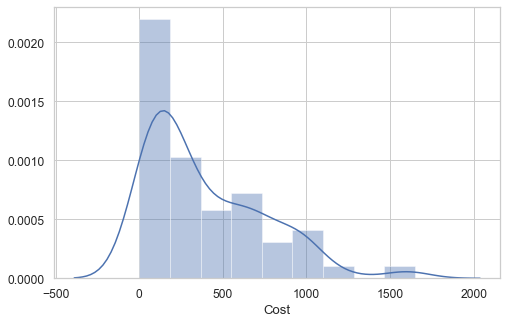

In [82]:
sns.distplot(data["Cost"])

The last bin is kind of disjoint from the other histogram bins. This reinforced the idea that outliear exist. Also, the first bin contains price of 0 as well. There are very less price for a bag. The distant cost should be in the last bin of the plot. Let see deeper with other plots as well.

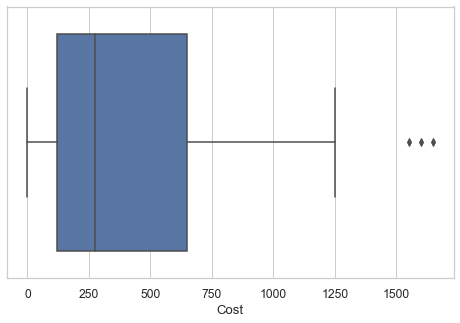

In [83]:
sns.boxplot(x="Cost", data=data)

*Cost* have outlier with values more that 1250

Similarly `boxplot` of *Weight*, *Weight1*, *Height* are clearly visible.

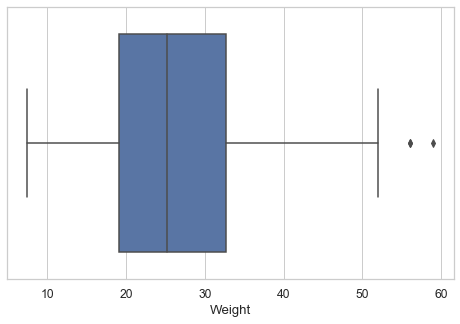

In [84]:
sns.boxplot(x=data["Weight"])

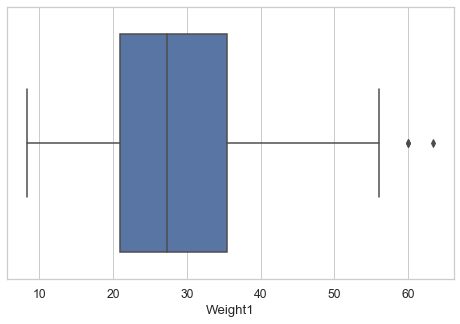

In [85]:
sns.boxplot(x=data["Weight1"])

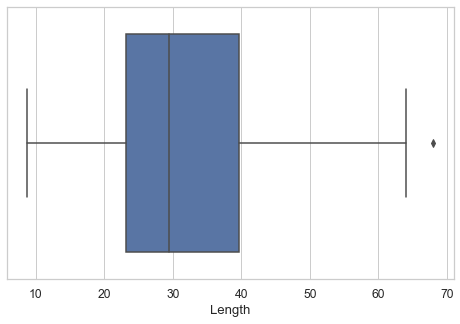

In [86]:
sns.boxplot(x=data["Length"])

**From the above boxplots it is obvious that following are outliers**
* data["Cost"] > 1250
* data["Weight"] > 55
* data["Weight1"] > 55
* data["Length] > 65

#### Let see the outliers data.

In [87]:
outliers = (data.loc[(data["Cost"] < 100) | (data["Cost"] > 1250)]).sort_values(by=["Cost"])
outliers.head()

,Cost,Weight,Weight1,Length,Height,Width
40,0.0,19.0,20.5,22.8,6.4752,3.3516
72,5.9,7.5,8.4,8.8,2.1120,1.4080
145,6.7,9.3,9.8,10.8,1.7388,1.0476
147,7.0,10.1,10.6,11.6,1.7284,1.1484
146,7.5,10.0,10.5,11.6,1.9720,1.1600


There are multiple strategies to deal with outliers. For now I am removing them.

In [88]:
data = data.loc[(data["Cost"] > 100) & (data["Cost"] < 1250)]

# **Building Linear Regression Models**

#### *Cost/Loss function is defined as:*

$ J(\theta) = \frac{1}{(2m)} \sum\limits_{i=1}^{m} (h(\theta)^{(i)} - y^{(i)})^2 \\
\\
m = total \ number \ of \ observations \\
\theta = weights \\
h(\theta) = \ hypothesis \\
y = observed \ target \ value \\
i = i^{th} \ sample \ data
$

### *Gradient defined as:*

$ \frac{\partial J(\theta)}{\partial \theta_j} = \frac{1}{(m)} \sum\limits_{i=1}^{m} ((h(\theta)^{(i)} - y^{(i)})^2)X_j^{(i)} \\
\\
m = total \ number \ of \ observations \\
\theta = weights \\
h(\theta) = \ hypothesis \\
y = observed \ target \ value \\
i = i^{th} \ sample \ data
$

## **Linear regression using Gradient Descent**

Calculating the cost give by: $ J(\theta) = \frac{1}{(2m)} \sum\limits_{i=1}^{m} (h(\theta)^{(i)} - y^{(i)})^2$

In [92]:
def cal_cost_gd(theta, X, y):
    m = len(y)
    predictions = X.dot(theta)
    cost = (1/2*m) * np.sum(np.square(predictions-y))
    return cost

Calulating thetas given by: 


$\frac{\partial J(\theta)}{\partial \theta_j} = \frac{1}{(m)} \sum\limits_{i=1}^{m} ((h(\theta)^{(i)} - y^{(i)})^2)X_j^{(i)}$


and updating thetas on every iteration:

$\theta_j := \theta_j - a.(\frac{\partial J(\theta)}{\partial \theta_j} = \frac{1}{(m)} \sum\limits_{i=1}^{m} ((h(\theta)^{(i)} - y^{(i)})^2)X_j^{(i)})$

In [93]:
def gradient_descent_gd(X, y, theta, learning_rate=0.01, iterations=100):
    m = len(y)
    cost_history = np.zeros(iterations)
    theta_history = np.zeros((iterations, X.shape[1]))
    for it in range(iterations):
        prediction = np.dot(X, theta)
        error = (prediction - y)
        gradient = (X.T.dot(error))
        new_gradient = (1 / m) * learning_rate * gradient
        theta = theta - new_gradient
        theta_history[it, :] = theta.T
        cost_history[it] = cal_cost_gd(theta, X, y)
    return theta, cost_history, theta_history

In [94]:
# Creating copy of data to work with
df_gd = data.copy()

In [96]:
# verifying expected shape.
df_gd.shape

(123, 6)

In [97]:
# scaling the data
scaler_gd = StandardScaler()
df_gd_scaled = scaler_gd.fit_transform(df_gd)

In [98]:
# separting target and feature variables.
X_gd = df_gd_scaled[:, 1:]
y_gd = df_gd_scaled[:, 0]
print(X_gd.shape)
print(y_gd.shape)

(123, 5)
(123,)


In [99]:
# split training and testing data
X_train_gd, X_test_gd, y_train_gd, y_test_gd = train_test_split(X_gd, y_gd, train_size=0.8)
print(X_train_gd.shape)
print(X_test_gd.shape)
print(y_train_gd.shape)
print(y_test_gd.shape)

(98, 5)
(25, 5)
(98,)
(25,)


In [100]:
# reshape in tuple of (1, 1).
y_train_gd = y_train_gd.reshape(-1, 1)
y_test_gd = y_test_gd.reshape(-1, 1)
print(y_train_gd.shape)
print(y_test_gd.shape)

(98, 1)
(25, 1)


In [101]:
# prepending "1" to the training set. This is for vector multiplication.
X_train_gd_1 = np.c_[np.ones((len(X_train_gd), 1)), X_train_gd]
X_test_gd_1 = np.c_[np.ones((len(X_test_gd), 1)), X_test_gd]
print(X_train_gd.shape)
print(X_test_gd.shape)

(98, 5)
(25, 5)


In [102]:
# setting hyper parameters and running the gradient decent function.
lr_gd = 0.05
n_iter_gd = 100
theta_gd = np.random.randn(X_train_gd_1.shape[1], 1)
theta_rs_gd, cost_history_rs_gd, theta_history_rs_gd = gradient_descent_gd(X_train_gd_1, y_train_gd, theta_gd, lr_gd, n_iter_gd)
print("Final Thetas = ",theta_rs_gd)

Final Thetas =  [[ 0.0166    ]
 [ 0.15578543]
 [-0.15967243]
 [ 0.50126397]
 [ 0.30088897]
 [ 0.30326012]]


In [103]:
# generating predictions from the model
y_pred_gd = np.dot(X_test_gd_1, theta_rs_gd)

**MSE, RMSE and R squared of the model are following:**

In [104]:
print("Coefficient = ", theta_rs_gd[0, 0])
print("Mean Squared Error (MSE) = {:0.3f}".format(cost_history_rs_gd[-1]))
print("Root Mean Squared Error (RMSE) = {:0.3f}: ".format(np.sqrt(cost_history_rs_gd[-1])))
print("r2_score = {:0.3f}".format(metrics.r2_score(y_test_gd, y_pred_gd)))

Coefficient =  0.01660000013296847
Mean Squared Error (MSE) = 358.712
Root Mean Squared Error (RMSE) = 18.940: 
r2_score = 0.927


#### **Plot of loss function output over iteration**

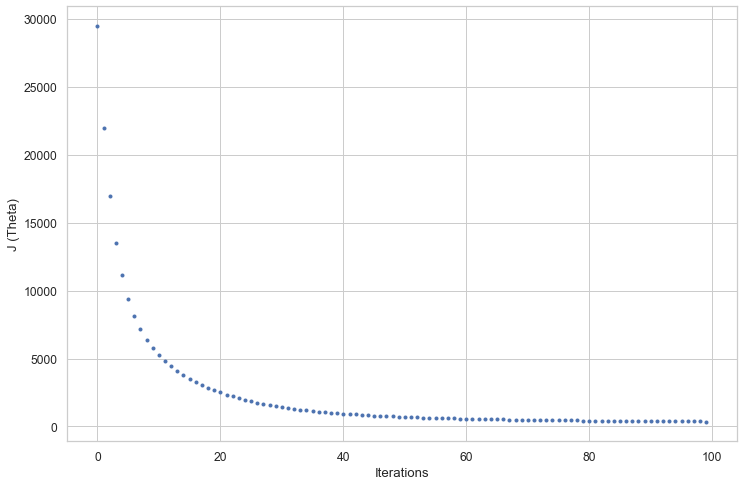

In [105]:
fig,ax = plt.subplots(figsize=(12,8))
ax.set_ylabel('J (Theta)')
ax.set_xlabel('Iterations')
_= ax.plot(range(n_iter_gd),cost_history_rs_gd, 'b.')